In [1]:
import os
from os.path import dirname

root_dir = dirname(os.getcwd())
os.chdir(root_dir)

In [2]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.nn.ode import get_solution
from src.utils.data import extract_params, extract_cumulative_cases, extract_temperature_rainfall

In [3]:
location = 'sanjuan'
data_csv_path = f'data/projection/{location}/data.csv'
predicted_params_path = f'results/{location}/best_params.yaml'

In [4]:
param_dict = extract_params(predicted_params_path)
cumulative_cases = extract_cumulative_cases(data_csv_path).log1p()
temperature_data, rainfall_data = extract_temperature_rainfall(data_csv_path)

In [5]:
for k, v in param_dict.items():
    param_dict[k] = torch.tensor(v, dtype=torch.float32)

/tmp/ipykernel_105597/943418920.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


In [6]:
t_original = torch.linspace(
    0,
    1,
    steps=len(cumulative_cases),
    dtype=torch.float32,
)
t_eval = torch.linspace(
    0,
    1,
    steps=len(cumulative_cases),
    dtype=torch.float32,
)

In [7]:
state_order = [
    'E_0', 'L_0', 'P_0', 'M_s_0', 'M_e_0', 'M_i_0',
    'H_s_0', 'H_e_0', 'H_i_0', 'H_r_0'
]
y0_list = [cumulative_cases[0]]
for state_name in state_order:
    state_val = param_dict[state_name]
    y0_list.append(torch.atleast_1d(state_val))
y0 = torch.stack(y0_list).squeeze(-1)

In [8]:
solution = get_solution(
    t_eval=t_eval,
    t_original=t_original,
    y0=y0,
    temperature_arr=temperature_data,
    rainfall_arr=rainfall_data,
    param_dict=param_dict,
)

In [9]:
pred_data_normalized = solution.t()[0][1:]
true_data_normalized = cumulative_cases[1:].squeeze()

pred_data = pred_data_normalized.expm1()
true_data = true_data_normalized.expm1()

In [11]:
criterion = torch.nn.MSELoss()
loss_normalized = criterion(pred_data_normalized, true_data_normalized)
loss = criterion(pred_data, true_data)

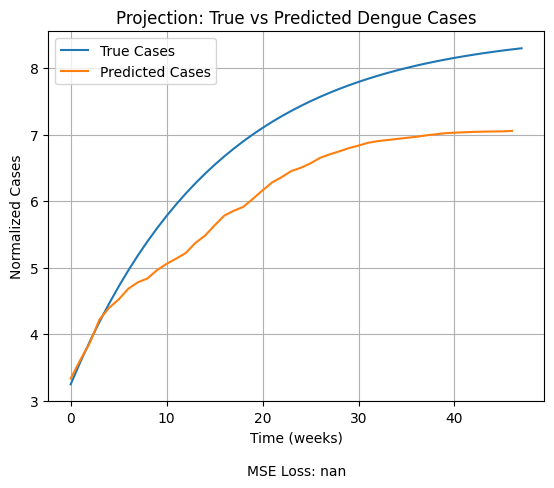

In [12]:
fig1, ax1_fig1 = plt.subplots()
ax1_fig1.plot(pred_data_normalized, label='True Cases')
ax1_fig1.plot(true_data_normalized, label='Predicted Cases')
ax1_fig1.set_xlabel('Time (weeks)')
ax1_fig1.set_ylabel('Normalized Cases')
ax1_fig1.set_title('Projection: True vs Predicted Dengue Cases')
ax1_fig1.text(0.5, -0.2, f'MSE Loss: {loss_normalized:.4f}', transform=ax1_fig1.transAxes, ha='center')
ax1_fig1.legend()
ax1_fig1.grid(True)
plt.show()

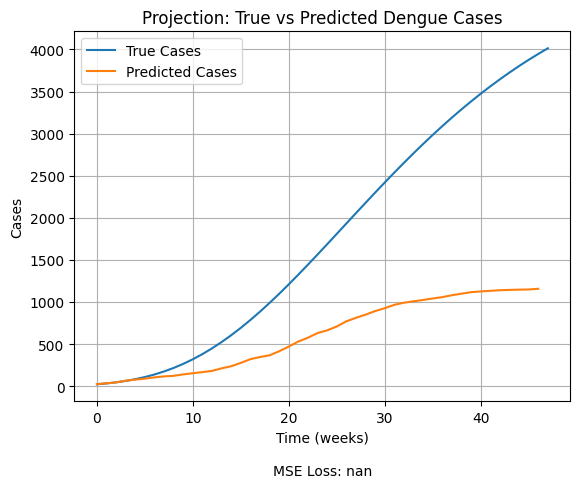

In [13]:
fig2, ax1_fig2 = plt.subplots()
ax1_fig2.plot(pred_data, label='True Cases')
ax1_fig2.plot(true_data, label='Predicted Cases')
ax1_fig2.set_xlabel('Time (weeks)')
ax1_fig2.set_ylabel('Cases')
ax1_fig2.set_title('Projection: True vs Predicted Dengue Cases')
ax1_fig2.text(0.5, -0.2, f'MSE Loss: {loss:.4f}', transform=ax1_fig2.transAxes, ha='center')
ax1_fig2.legend()
ax1_fig2.grid(True)
plt.show()

In [14]:
fig1.savefig(f'results/{location}/normalized_projection.png', bbox_inches='tight')
fig2.savefig(f'results/{location}/cumulative_projection.png', bbox_inches='tight')